In [52]:
DOCUMENT_ID = '17F5_gi-40-fPIS24IOgAQZnJ9vqeomjbvBs_1Oswrho'

# Prototype

Insert matplotlib in Google Docs with `DOCUMENT_ID`.

## Requirements

1. Insert placeholder for Jupyter with Jupyter Integration. More details at https://docs.google.com/document/d/17F5_gi-40-fPIS24IOgAQZnJ9vqeomjbvBs_1Oswrho/edit#.
1. Install `matplotlib`, `google-api-python-client`, `google-auth-httplib2`, `google-auth-oauthlib`

In [ ]:
!pip install --upgrade matplotlib google-api-python-client google-auth-httplib2 google-auth-oauthlib

## Load Libraries

In [53]:
import os.path

In [54]:
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import googleapiclient.http

In [55]:
import matplotlib.pyplot as plt

## Get Credentials

In [56]:
# If modifying these scopes, delete the file token.json.
SCOPES = [
    "https://www.googleapis.com/auth/drive.file",
    "https://www.googleapis.com/auth/drive.file",
]

In [57]:
creds = None
# The file token.json stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists("token.json"):
    creds = Credentials.from_authorized_user_file("token.json", SCOPES)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file("credentials.json", SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open("token.json", "w") as token:
        token.write(creds.to_json())

## Create Chart

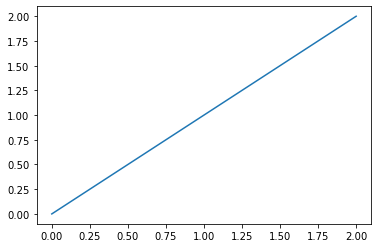

In [58]:
plt.plot([0, 1, 2], [0, 1, 2])
plt.savefig("/tmp/demo.png")

## Upload Chart to Google Drive

In [59]:
try:
    drive_service = build("drive", "v3", credentials=creds)
except HttpError as err:
    print(err)

In [60]:
try:
    file_metadata = {"name": "demo.png"}
    media = googleapiclient.http.MediaFileUpload("/tmp/demo.png", mimetype="image/png")
    chart_in_drive = (
        drive_service.files()
        .create(body=file_metadata, media_body=media, fields="id")
        .execute()
    )
except HttpError as err:
    print(err)

Need to change permission to public.

In [61]:
try:
    new_permission = (
        drive_service.permissions()
        .create(
            fileId=chart_in_drive.get("id"),
            body={
                "role": "reader",
                "type": "anyone",
            },
        )
        .execute()
    )
except HttpError as err:
    print(err)

## Get Existing Google Doc

In [62]:
try:
    service = build("docs", "v1", credentials=creds)
except HttpError as err:
    print(err)

In [63]:
DOCUMENT_ID = '17F5_gi-40-fPIS24IOgAQZnJ9vqeomjbvBs_1Oswrho'

In [64]:
try:
    # Retrieve the documents contents from the Docs service.
    document = service.documents().get(documentId=DOCUMENT_ID).execute()

    print("The title of the document is: {}".format(document.get("title")))
except HttpError as err:
    print(err)

The title of the document is: Jupyter Notebook to Google Docs Demo


# Get Location to Insert Chart

In [65]:
placeholder_in_google_doc = None

for key, inline_object in document['inlineObjects'].items():
    try:
        if inline_object['inlineObjectProperties']['embeddedObject']['title'] == 'Placeholder for Jupyter':
            placeholder_in_google_doc = key
    except:
        pass

In [66]:
placeholder_in_google_doc

'kix.j3o9w9xaau20'

In [67]:
start_index = None

for fragment in document['body']['content']:   
    if 'paragraph' in fragment:
        for element in fragment["paragraph"]['elements']:
            if 'inlineObjectElement' in element:
                start_index = element['startIndex']

In [68]:
start_index

871

## Insert Image to Google Doc

In [69]:
def id2uri(id):
    return f"https://drive.google.com/uc?id={id}&export=download"

In [70]:
uri = id2uri(chart_in_drive.get("id"))

In [71]:
try:
    requests = [
        {
            "insertInlineImage": {
                "location": {"index": start_index},
                "uri": uri,  # Need to be public
                "objectSize": {
                    "height": {"magnitude": 50, "unit": "PT"},
                    "width": {"magnitude": 50, "unit": "PT"},
                },
            }
        }
    ]

    # Execute the request.
    body = {"requests": requests}
    response = (
        service.documents().batchUpdate(documentId=DOCUMENT_ID, body=body).execute()
    )
    insert_inline_image_response = response.get("replies")[0].get("insertInlineImage")
    print(
        "Inserted image with object ID: {0}".format(
            insert_inline_image_response.get("objectId")
        )
    )
except HttpError as err:
    print(err)

Inserted image with object ID: kix.koispy4yrlum


# Delete Placeholder

In [72]:
try:
    requests = [
        {
            "deleteContentRange": {
                "range": {
                      "startIndex": start_index + 1,
                      "endIndex": start_index + 2
                }
            }
        }
    ]

    # Execute the request.
    body = {"requests": requests}
    response = (
        service.documents().batchUpdate(documentId=DOCUMENT_ID, body=body).execute()
    )
except HttpError as err:
    print(err)